In [77]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [78]:
# We'll go through a toy example of binary classification -
# Person A is deciding whether they will go on a second date with Person B.
# It will depend on their looks, eloquence, alcohol consumption (only for example),
# and how much money was spent on the first date.

# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]


features = ['Looks', 'Alcoholic_beverage','Eloquence','Money_spent']

df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                         'repulsive', 'repulsive', 'handsome'] 
df_train['Alcoholic_beverage'] = ['yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                                   'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                                  'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


In [79]:
df_test = { }
df_test['Looks'] = ['handsome', 'handsome', 'repulsive'] 
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [80]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Eloquence_high,Alcoholic_beverage_yes,Eloquence_average,Money_spent_lots,Looks_handsome,Money_spent_little,Alcoholic_beverage_no,Looks_repulsive
0,1,1,0,1,1,0,0,0
1,0,1,0,0,1,1,0,0
2,0,0,1,1,1,0,1,0
3,0,0,1,0,0,1,1,1
4,0,1,0,1,0,0,0,1
5,1,1,0,1,0,0,0,1
6,0,1,1,1,1,0,0,0


In [81]:
df_test

,Eloquence_high,Alcoholic_beverage_yes,Eloquence_average,Money_spent_lots,Looks_handsome,Money_spent_little,Alcoholic_beverage_no,Looks_repulsive
0,0,0,1,1,1,0,1,0
1,1,1,0,0,1,1,0,0
2,0,1,1,1,0,0,0,1


In [82]:
# Shannon Entropy
# What is the entropy  S0  of the initial system?
# By system states, we mean values of the binary feature "Will_go" - 0 or 1 - two states in total.

# S0 = -(4/7*log2 4/7 + 3/7*log2 3/7) => -(-0,807*4/7 - 1,222*3/7) => 0.984

In [83]:
# Shannon Entropy
# Let's split the data by the feature "Looks_handsome".
# What is the entropy  S1  of the left group - the one with "Looks_handsome".
# What is the entropy  S2  in the opposite group?
# What is the information gain (IG) if we consider such a split?

# S1 = -(3/4*log2 3/4 + 1/4*log2 1/4) => -(-0.75*0.415 - 0.25*2) => 0.811
# S2 = -(2/3*log 2/3 + 1/3*log2 1/3) => -(-0.666*0,586 - 0.333*1,586) => 0.917
# GI("Looks_handsome") = S0 - (4/7*S1 + 3/7*S2) => 0.984 - (0.811*4/7 + 0.917*3/7) => 0.127

In [84]:
# Train a decision tree using sklearn on the training data.
# You may choose any depth for the tree.

decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=13, random_state=7)
decision_tree.fit(df_train, y);  # Build a decision tree classifier from the training set (X, y).

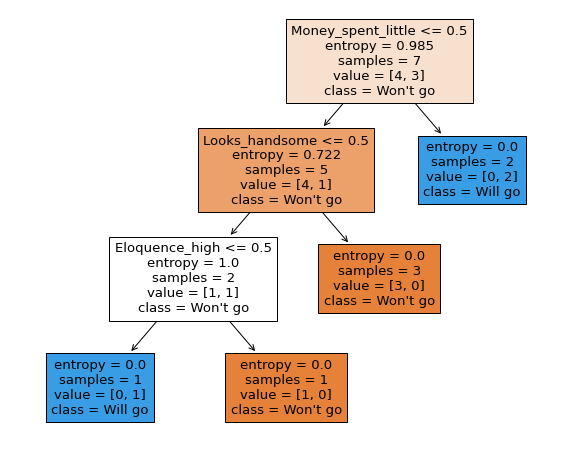

In [85]:
# Additional: display the resulting tree using graphviz. You can use pydot or web-service dot2png.

plot_tree(
    decision_tree,                        
    feature_names=df_train.columns,
    filled=True,                         # color
    class_names=["Won't go", "Will go"]
);

In [86]:
# Consider the following warm-up example: we have 9 blue balls and 11 yellow balls.
# Let ball have label 1 if it is blue, 0 otherwise.

balls = [1 for i in range(9)] + [0 for i in range(11)]
# two groups
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 blue and 6 yellow

In [87]:
# Shannon Entropy calculator
import math


def get_shannon_entropy(data_raw: list):
    entropy = 0 
    data = [str(el) for el in data_raw]  # Crutch for a data frame
    for sample in set(data):
        sample_div_data = data.count(sample) / len(data)
        entropy -= sample_div_data * math.log(sample_div_data, 2)
    
    return entropy


print(get_shannon_entropy(balls)) # 9 blue и 11 yellow
print(get_shannon_entropy(balls_left)) # 8 blue и 5 yellow
print(get_shannon_entropy(balls_right)) # 1 blue и 6 yellow
print(get_shannon_entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided die        

0.9927744539878084
0.961236604722876
0.5916727785823275
2.584962500721156


In [88]:
# IG calculator.

def get_ig(root, sub_root_a, sub_root_b):
    ig = get_shannon_entropy(root) \
         - len(sub_root_a) / len(root) * get_shannon_entropy(sub_root_a) \
         - len(sub_root_b) / len(root) * get_shannon_entropy(sub_root_b)

    return ig

print(get_ig(balls, balls_left, balls_right))    

0.16088518841412436


In [89]:
# Implement a decision tree building algorithm by calling get_ig recursively

def get_best_feat_to_split(split_candidate, target_feature):
    result = {
        feature: get_ig(
            target_feature,
            target_feature[split_candidate[feature]==0],
            target_feature[split_candidate[feature]==1])
        for feature in split_candidate.columns
    }
    
    return result

get_best_feat_to_split(df_train, y)

{'Eloquence_high': 0.2916919971380598,
 'Alcoholic_beverage_yes': 0.005977711423774124,
 'Eloquence_average': 0.02024420715375619,
 'Money_spent_lots': 0.46956521111470706,
 'Looks_handsome': 0.12808527889139454,
 'Money_spent_little': 0.46956521111470706,
 'Alcoholic_beverage_no': 0.005977711423774124,
 'Looks_repulsive': 0.12808527889139454}

In [90]:
data_train = pd.read_csv('adult_train.csv')
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [91]:
data_test = pd.read_csv('adult_test.csv')
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [92]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# encode target variable as integer
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

In [93]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

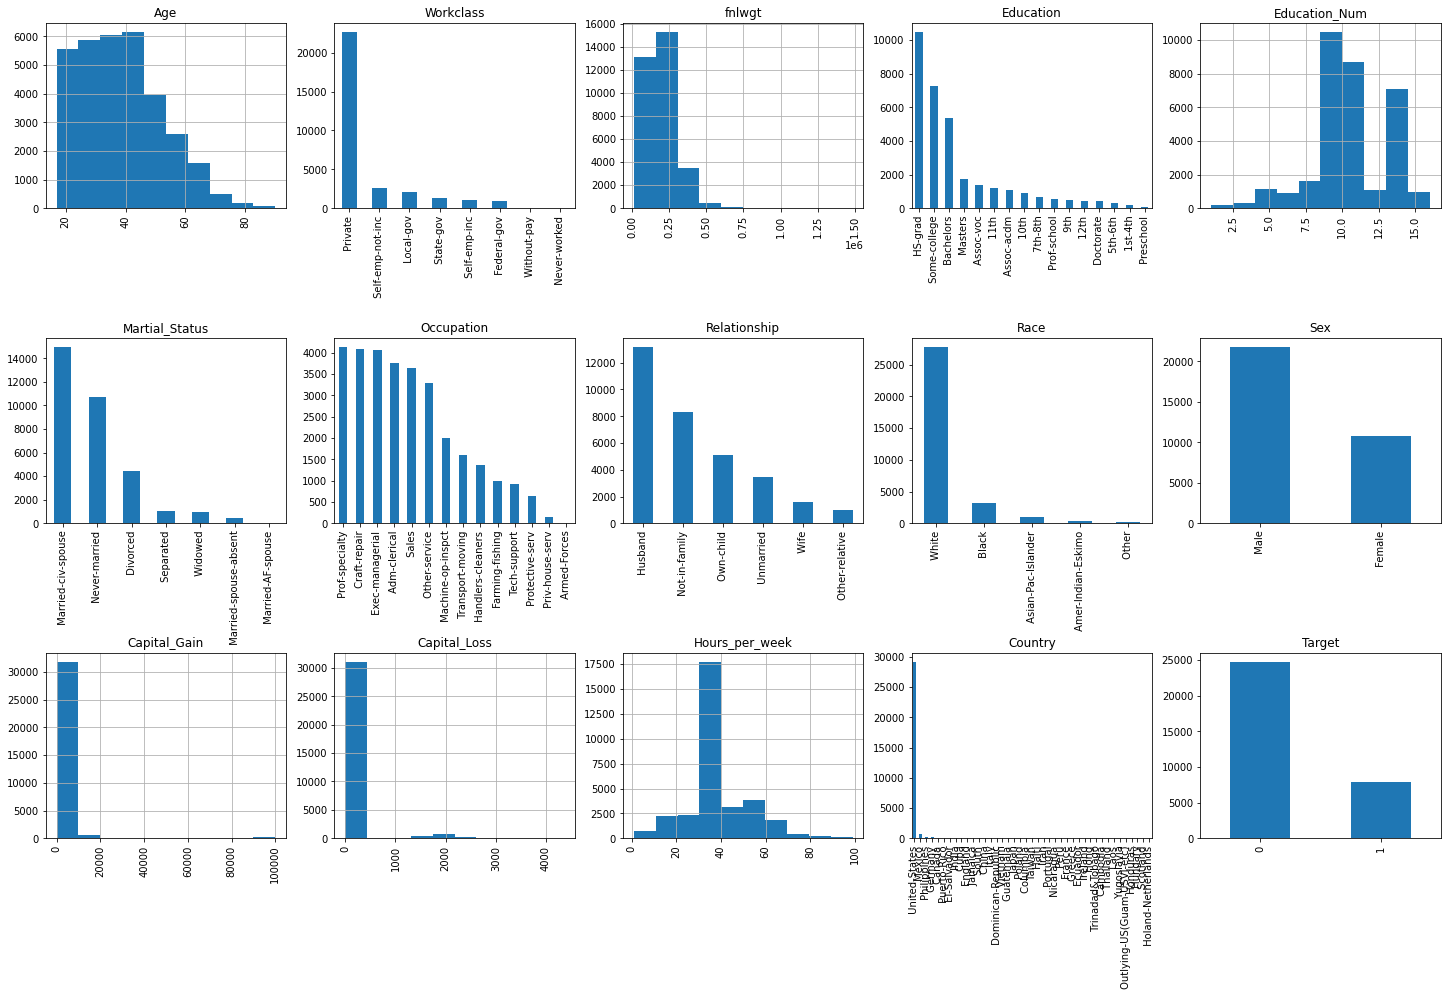

In [95]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)

for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
        
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
        
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [96]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [97]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

In [98]:
# As we see, in the test data, age is treated as type object. We need to fix this.

data_test['Age'] = data_test['Age'].astype(int)

# Also we'll cast all float features to int type to keep types consistent between our train and test data.
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

In [99]:
# choose categorical and continuous features from data

categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [100]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [101]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)
    
for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [102]:
# no more missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [103]:
# We'll dummy code some categorical features: Workclass, Education, Martial_Status,
# Occupation, Relationship, Race, Sex, Country. It can be done via pandas method get_dummies

data_train = pd.concat([data_train[numerical_columns],
    pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
    pd.get_dummies(data_test[categorical_columns])], axis=1)

In [104]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [105]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

In [106]:
# There is no Holland in the test data. Create new zero-valued feature.

data_test['Country_ Holand-Netherlands'] = 0
set(data_train.columns) - set(data_test.columns)

set()

In [107]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [108]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [109]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

In [110]:
# Train a decision tree (DecisionTreeClassifier) with a maximum depth of 3,
# and evaluate the accuracy metric on the test data.
# Use parameter random_state = 17 for results reproducibility.

decision_tree = DecisionTreeClassifier(
    max_depth=3,  # If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    random_state=17
)

In [111]:
ecision_tree = DecisionTreeClassifier(
    max_depth=3,  # If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    random_state=17
)

decision_tree.fit(X_train, y_train)

# Make a prediction with the trained model on the test data.
tree_predictions = decision_tree.predict(X_test)

# What is the test set accuracy of a decision tree with maximum tree depth of 3 and random_state = 17?
accuracy_score(y_test, tree_predictions)

0.8447884036607088

In [112]:
tree_predictions

array([0, 0, 0, ..., 1, 0, 1])

In [113]:
# Train a decision tree (DecisionTreeClassifier, random_state = 17).
# Find the optimal maximum depth using 5-fold cross-validation (GridSearchCV).

# %%time
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=17),
    tree_params, cv=5
) 

locally_best_tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(2, 11)}, pre_dispatch='2*n_jobs',
  

In [114]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8565770273854106


In [115]:
# Train a decision tree with maximum depth of 9 (it is the best max_depth in my case),
# and compute the test set accuracy. Use parameter random_state = 17 for reproducibility.

tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)  # Строит дерево. Автоматом подбирая условие деления что энтропия была минимальной, а рост информации - максимальным.
tuned_tree_predictions = tuned_tree.predict(X_test)  # Проходит по построенному дереву (выполняя условия выбора направления в данном узле). В листе содержится значение целевого признака.

# What is the test set accuracy of a decision tree with maximum depth of 9 and random_state = 17?
accuracy_score(y_test, tuned_tree_predictions)

0.847798046803022

In [116]:
# Train a random forest (RandomForestClassifier). Set the number of trees to 100 and use random_state = 17.

rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [117]:
# Make predictions for the test data and assess accuracy.
forest_predictions = rf.predict(X_test)
accuracy_score(y_test,forest_predictions) # Сравнивает целевой признак с предсказанием.

0.8585467723112831

In [ ]:
# Train a random forest (RandomForestClassifier).
# Tune the maximum depth and maximum number of features for each tree using GridSearchCV.
# Случайный лес (композиция многих деревьев) усредняет ответы деревьев, построенных до максимальной глубины.

forest_params = {'max_depth': range(10, 16),
                 'max_features': range(5, 105, 20)}

locally_best_forest = GridSearchCV(
    RandomForestClassifier(
        n_estimators=10,
        random_state=17,
        n_jobs=-1
    ),
    forest_params, cv=3, verbose=1
)
locally_best_forest.fit(X_train, y_train)